In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader.cluster import ClusterData
import dgl 
import torch as th
from dgl.data import RedditDataset, YelpDataset
from dgl.distributed import partition_graph
from ogb.nodeproppred import DglNodePropPredDataset
from torch_geometric.utils import to_torch_coo_tensor
from ogb.nodeproppred import NodePropPredDataset
import networkx as nx 
from adjacency import load_data
from scipy.sparse import csc_array
import numpy as np
import matspy as spy

/home/kit/aifb/cc7738/anaconda3/envs/EAsF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_ogb_dataset(name, data_path):
    if name.startswith('ogbn'):
        dataset = DglNodePropPredDataset(name=name, root=data_path)
        split_idx = dataset.get_idx_split()
        g, label = dataset[0]
        n_node = g.num_nodes()
        node_data = g.ndata
        node_data['label'] = label.view(-1).long()
        node_data['train_mask'] = torch.zeros(n_node, dtype=torch.bool)
        node_data['val_mask'] = torch.zeros(n_node, dtype=torch.bool)
        node_data['test_mask'] = torch.zeros(n_node, dtype=torch.bool)
        node_data['train_mask'][split_idx["train"]] = True
        node_data['val_mask'][split_idx["valid"]] = True
        node_data['test_mask'][split_idx["test"]] = True
    else:
        raise NotImplementedError
    return g

In [3]:
def ogb_to_dgl(data):
    
    # Extract node features, edge index, and labels
    x = data[0]['node_feat'] # Node features
    edge_index = data[0]['edge_index'] # Edge index
    y = data[1] # Node labels

    # Convert to DGLGraph
    g = dgl.DGLGraph()
    g.add_nodes(x.shape[0])  # Number of nodes
    g.add_edges(edge_index[0], edge_index[1])  # Edges (from PyG tuple format

    # Set node features and labels
    g.ndata['feat'] = torch.FloatTensor(x)
    g.ndata['label'] = torch.tensor(y[:, 0], dtype=torch.long)
    
    return g

In [4]:
def tag_to_dgl(data):
    print(data)
    # transform to dgl graph
    g = dgl.DGLGraph()
    g.add_nodes(data.num_nodes)  # Number of nodes
    g.add_edges(data.edge_index[0], data.edge_index[1])  # Edges (from PyG tuple format
    g.ndata['feat'] = data.x
    g.ndata['label'] = data.y
    g.ndata['train_mask'] = data.train_mask
    g.ndata['val_mask'] = data.val_mask
    g.ndata['test_mask'] = data.test_mask
    return g


In [5]:
def egde_index_to_dense(edge_index, num_nodes):
    # transform sparse form into dense form
    row, col = edge_index
    data = np.ones(row.shape[0])
    return csc_array((data, (row, col)), shape=(num_nodes, num_nodes))

In [6]:
# params
name = 'cora'
num_clusters = 2

# data
if name in ['cora', 'citeseer']:
    data, num_class, text = load_data(name)
    
elif name in ['ogbn-arxiv', 'ogbn-products']:
    data = load_ogb_dataset(name, 'dataset')

In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_nodes=2708, train_id=[1624], val_id=[542], test_id=[542])

(<Figure size 374.752x374.655 with 1 Axes>,
 <Axes: title={'center': "2708×2708, 10556 'float64' elements, csc"}>)

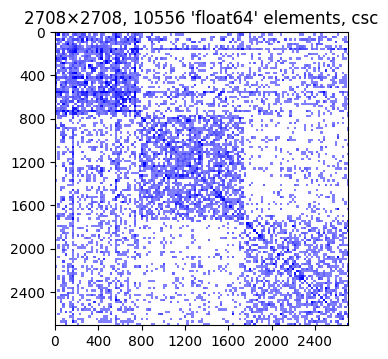

In [8]:
edge_index = egde_index_to_dense(data.edge_index, data.num_nodes)
spy.spy_to_mpl(edge_index)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_nodes=2708, train_id=[1624], val_id=[542], test_id=[542])
Converting to homogeneous graph takes 0.001s, peak mem: 3.876 GB
Convert a graph into a bidirected graph: 0.000 seconds, peak memory: 3.876 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 3.876 GB
Metis partitioning: 0.002 seconds, peak memory: 3.876 GB
Assigning nodes to METIS partitions takes 0.003s, peak mem: 3.876 GB
Reshuffle nodes and edges: 0.001 seconds
Split the graph: 0.002 seconds
Construct subgraphs: 0.002 seconds
Splitting the graph into partitions takes 0.006s, peak mem: 3.876 GB
part 0 has 1536 nodes and 1354 are inside the partition
part 0 has 5624 edges and 5358 are inside the partition
part 1 has 1540 nodes and 1354 are inside the partition
part 1 has 5464 edges and 5198 are inside the partition
Save partitions: 0.030 seconds, peak memory: 3.876 GB
There are 10556 edges in the graph

[01:31:56] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 2708 nodes and 10556 edges into 2 parts and get 266 edge cuts


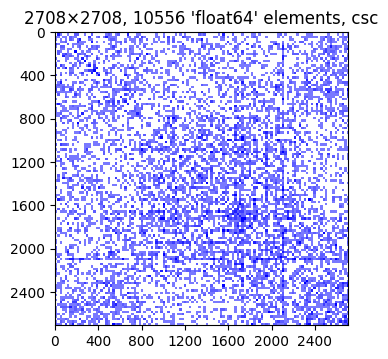

In [10]:
g = tag_to_dgl(data)
# partition the graph and node mapping
node_map, edge_map = partition_graph(g, 'test', num_clusters, out_path='output/',  part_method='metis',
                            balance_edges=False, return_mapping=True)


# Create a new graph with remapped features
remapped_g = dgl.DGLGraph()
remapped_g.add_nodes(data.num_nodes)  # Number of nodes
# remapped_g.add_edges(node_map[g.edges()[0]], node_map[g.edges()[1]])
remapped_g.add_edges(node_map[g.edges()[0].numpy()], node_map[g.edges()[1].numpy()])

adj_sparse = remapped_g.edges()

# replot remapped adjacency matrix
remapped_adjacency = egde_index_to_dense(adj_sparse, data.num_nodes)
fig, ax = spy.spy_to_mpl(remapped_adjacency)


In [ ]:
g.edges()[1]